In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
#!pip install segmentation-models
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import pickle
with open("preds_test_best_submission", "rb") as f:
    predictions=pickle.load(f)
    

In [3]:
predictions

array([[[[3.03110480e-02],
         [5.75327827e-03],
         [4.81995149e-03],
         ...,
         [7.86073878e-03],
         [8.10576696e-03],
         [2.99316794e-02]],

        [[7.21927499e-03],
         [1.36300223e-03],
         [1.17198355e-03],
         ...,
         [3.35230934e-03],
         [3.77636845e-03],
         [8.34139716e-03]],

        [[6.69780234e-03],
         [1.57038460e-03],
         [1.71847921e-03],
         ...,
         [3.60844028e-03],
         [3.49291507e-03],
         [8.23599659e-03]],

        ...,

        [[1.33736013e-02],
         [4.40403400e-03],
         [4.30833688e-03],
         ...,
         [6.35613978e-04],
         [7.72992906e-04],
         [2.71767285e-03]],

        [[1.78894997e-02],
         [6.17973832e-03],
         [3.65980412e-03],
         ...,
         [7.33048713e-04],
         [1.37665158e-03],
         [8.29461589e-03]],

        [[6.19511716e-02],
         [2.62808427e-02],
         [1.04246400e-02],
         ...,
 

In [4]:
test_predictions = np.where(predictions >= 0.500,1,0)

In [14]:
test_predictions

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


### added 100 gigabytes of memory limit

In [4]:

    

#with open("stage1/X_test", "rb") as f:
    #X_test=pickle.load(f)    
#preds_test=preds_test/8

In [5]:
im_width = 128
im_height = 128
im_chan = 1
test_ids=[]
path_test = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\test'
for i in os.listdir(os.path.join(path_test,"images")):
    test_ids.append(i)    
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


<ipython-input-5-b4647d3bd7b7>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Done!


In [6]:
def _get_share_ax(share_var, axarr, row, col):
    if share_var=='row':
        if col > 0:
            return axarr[row, col-1]
        return None
    elif share_var=='col':
        if row > 0:
            return axarr[row-1, col]
        return None
    elif share_var and (col>0 or row>0):
        return axarr[0,0]
    return None


def subplots_with_row_titles(nrows, ncols, row_titles=None, row_title_kw=None, sharex=False, sharey=False, subplot_kw=None, grid_spec_kw=None, **fig_kw):
    """
    Creates a figure and array of axes with a title for each row.
    
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(f'If row_titles is specified, there must be one for each row. Got={row_titles}')
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharex must be one of [True, False, "row", "col"]. Got={sharex}')
    if sharey not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharey must be one of [True, False, "row", "col"]. Got={sharey}')
        
    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for (row, big_ax) in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax._frameon = False
        
    axarr = np.empty((nrows, ncols), dtype='O')
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)
    
            ax= fig.add_subplot(nrows, ncols, row*ncols+col+1,
                                sharex=sharex_ax, sharey=sharey_ax, **subplot_kw)
            axarr[row, col] = ax
    return fig, axarr    

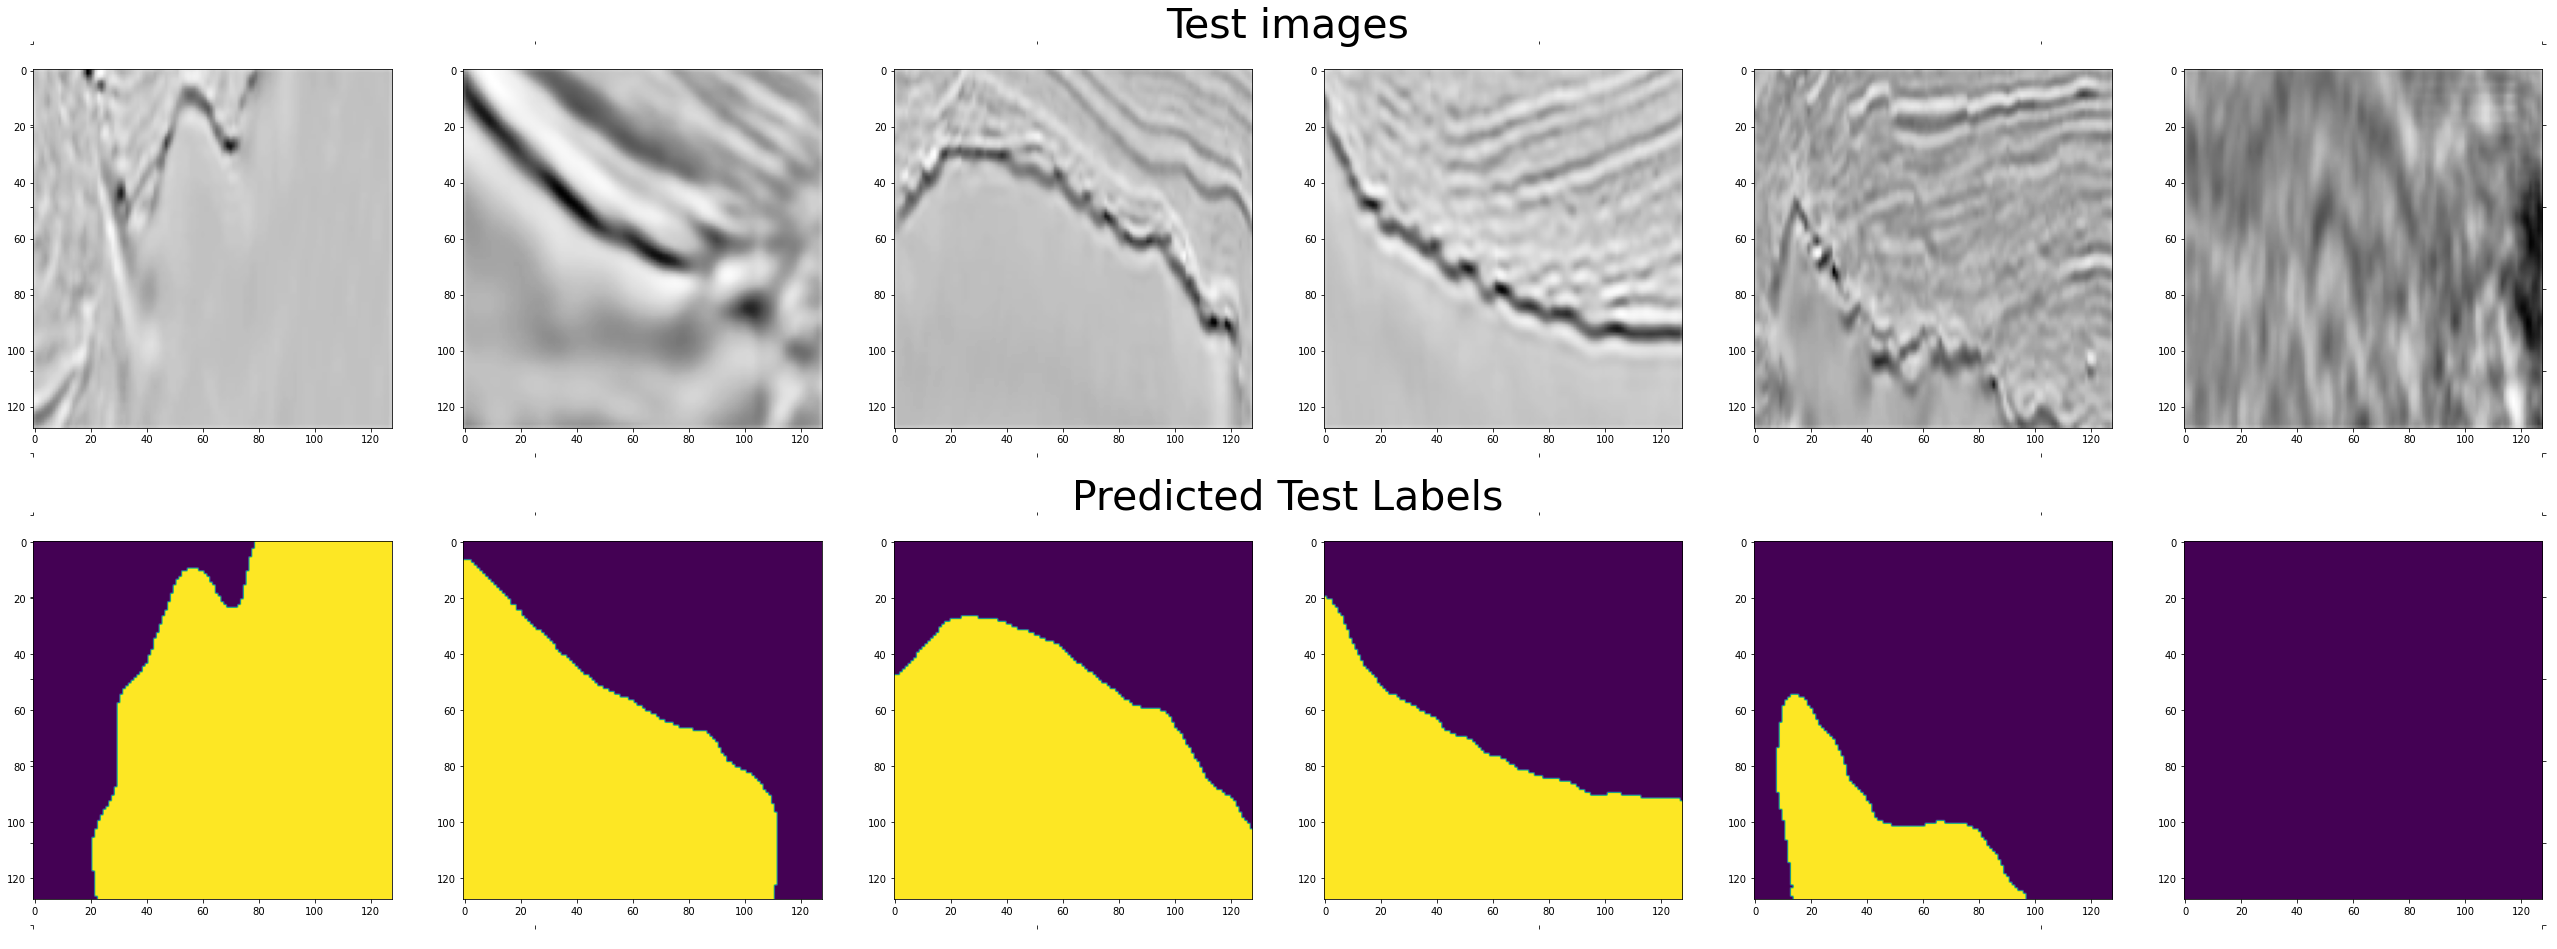

In [29]:
rows=2
cols=6
#fig,axes=plt.subplots(rows,cols)
#fig.set_figheight(30)
#fig.set_figwidth(90)
fig, axarr = subplots_with_row_titles(rows, cols, figsize=(cols*16, rows*12), 
                                      row_titles=['Test images','Predicted Test Labels'], 
                                      row_title_kw=dict(fontsize=41),
                                      sharex='row')
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.463, 
                    top=0.61, 
                    wspace=0.2, 
                    hspace=0.15)
for ind,i in enumerate([124,223,142,155,151,188]):
    axarr[0][ind].imshow(X_test[i],cmap='Greys')
    axarr[1][ind].imshow(test_predictions[i])
plt.savefig(os.path.join('plots/','seismic_sections_and_predictions_greys_2.png'), dpi=300,facecolor='w',bbox_inches='tight')

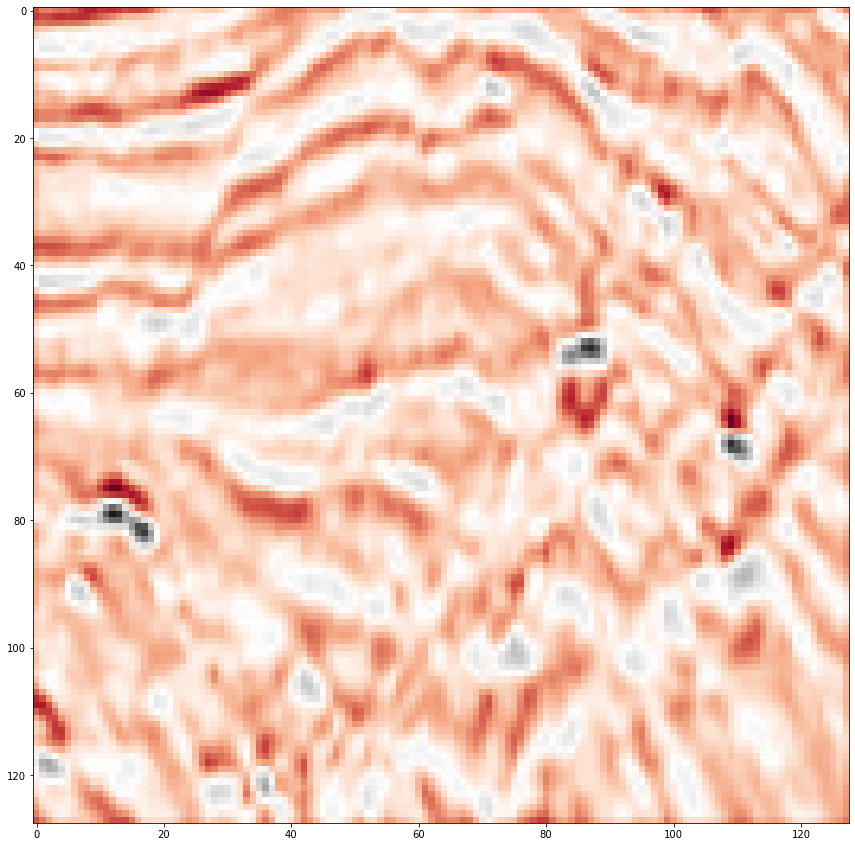

In [38]:
#for 
fig,axes=plt.subplots(1,1, figsize=(15, 15))
axes.imshow(X_test[162],cmap='RdGy')
plt.savefig(os.path.join('plots/','seismic_section_RdGy.png'), dpi=300,facecolor='w',bbox_inches='tight')

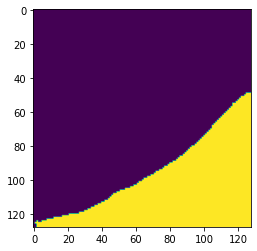

In [36]:
plt.imshow(test_predictions[96])

In [89]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\train'
path_test = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\test'
train_ids = next(os.walk(os.path.join(path_train,"images")))[2]
test_ids = next(os.walk(os.path.join(path_test,"images")))[2]

In [90]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


<ipython-input-90-ebd0e7c9c5c8>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
<ipython-input-90-ebd0e7c9c5c8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


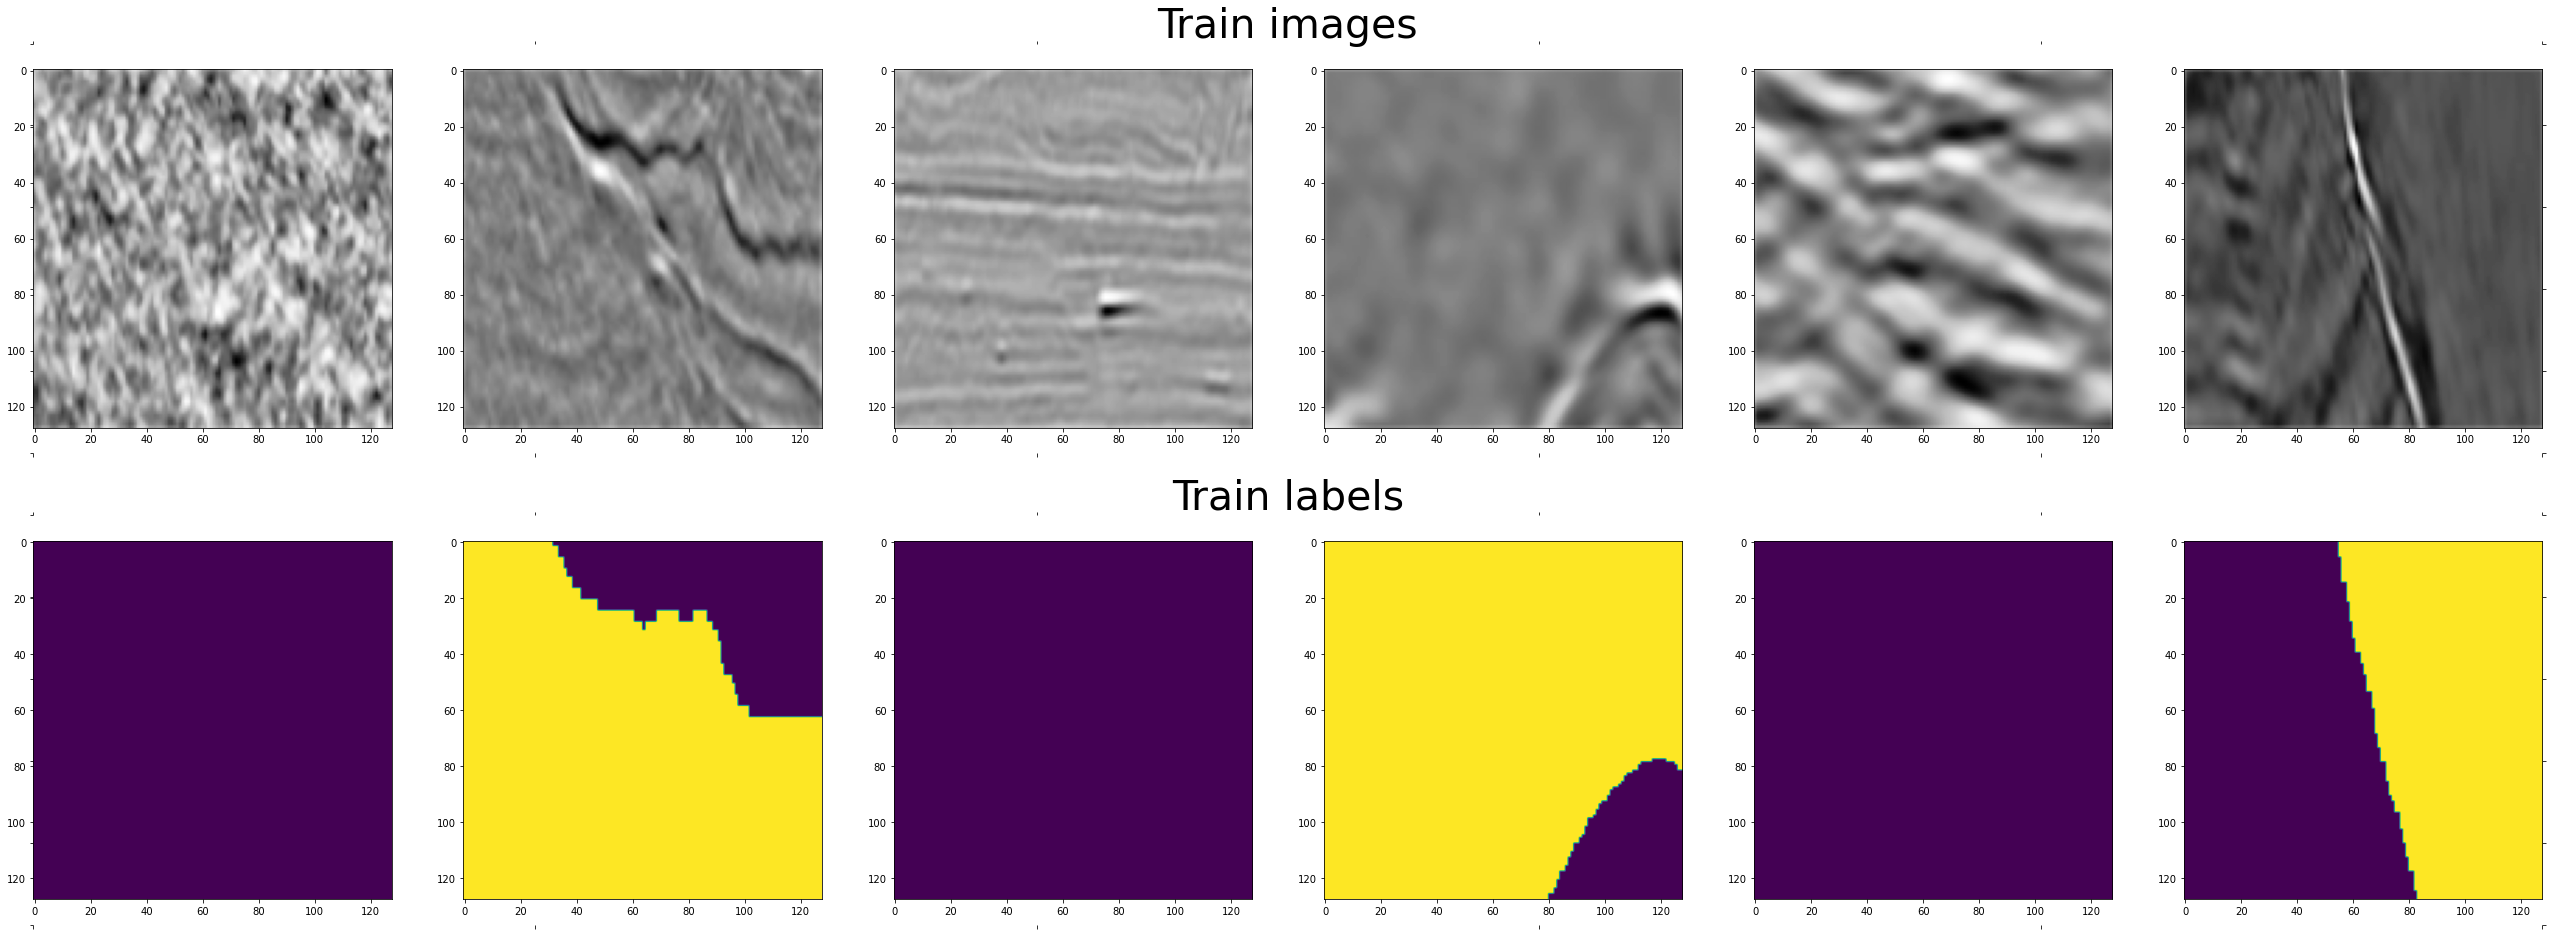

In [126]:
# Check if training data looks all right
#ix = random.randint(0, len(train_ids))

#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
#plt.show()
#tmp = np.squeeze(Y_train[ix]).astype(np.float32)
#plt.imshow(np.dstack((tmp,tmp,tmp)),cmap='Blues')
#plt.show()


rows=2
cols=6
#fig,axes=plt.subplots(rows,cols)
#fig.set_figheight(30)
#fig.set_figwidth(90)
fig, axarr = subplots_with_row_titles(rows, cols, figsize=(cols*16, rows*12), 
                                      row_titles=['Train images','Train labels'], 
                                      row_title_kw=dict(fontsize=41),
                                      sharex='row')
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.463, 
                    top=0.61, 
                    wspace=0.2, 
                    hspace=0.15)
for ind,i in enumerate(range(100,106,1)):
    axarr[0][ind].imshow(X_train[i],cmap='Greys')
    axarr[1][ind].imshow(Y_train[i])
plt.savefig(os.path.join('plots/','seismic_sections_and_labels_train_cmap_grays.png'), dpi=300,facecolor='w',bbox_inches='tight')

In [110]:
X_test[2]

array([[[129],
        [146],
        [146],
        ...,
        [ 67],
        [ 67],
        [ 56]],

       [[144],
        [162],
        [161],
        ...,
        [ 74],
        [ 76],
        [ 66]],

       [[144],
        [161],
        [159],
        ...,
        [ 71],
        [ 73],
        [ 65]],

       ...,

       [[150],
        [176],
        [183],
        ...,
        [169],
        [160],
        [134]],

       [[147],
        [173],
        [180],
        ...,
        [172],
        [161],
        [135]],

       [[128],
        [153],
        [158],
        ...,
        [156],
        [146],
        [122]]], dtype=uint8)

In [111]:
X_train[3]

array([[[132],
        [146],
        [144],
        ...,
        [125],
        [121],
        [104]],

       [[154],
        [171],
        [170],
        ...,
        [135],
        [130],
        [112]],

       [[160],
        [178],
        [178],
        ...,
        [130],
        [125],
        [107]],

       ...,

       [[116],
        [128],
        [127],
        ...,
        [189],
        [188],
        [168]],

       [[115],
        [128],
        [127],
        ...,
        [189],
        [188],
        [167]],

       [[102],
        [114],
        [114],
        ...,
        [168],
        [166],
        [147]]], dtype=uint8)

In [102]:
np.dstack((X_train[ix],X_train[ix],X_train[ix]))

array([[[73, 73, 73],
        [85, 85, 85],
        [93, 93, 93],
        ...,
        [79, 79, 79],
        [85, 85, 85],
        [72, 72, 72]],

       [[73, 73, 73],
        [86, 86, 86],
        [95, 95, 95],
        ...,
        [93, 93, 93],
        [94, 94, 94],
        [82, 82, 82]],

       [[63, 63, 63],
        [76, 76, 76],
        [84, 84, 84],
        ...,
        [96, 96, 96],
        [93, 93, 93],
        [83, 83, 83]],

       ...,

       [[80, 80, 80],
        [90, 90, 90],
        [89, 89, 89],
        ...,
        [92, 92, 92],
        [91, 91, 91],
        [81, 81, 81]],

       [[81, 81, 81],
        [91, 91, 91],
        [90, 90, 90],
        ...,
        [92, 92, 92],
        [91, 91, 91],
        [81, 81, 81]],

       [[72, 72, 72],
        [81, 81, 81],
        [80, 80, 80],
        ...,
        [82, 82, 82],
        [82, 82, 82],
        [72, 72, 72]]], dtype=uint8)